# Evaluating GSAT Score on Multiple Chinese LLM

In [48]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [49]:
dataset_df = pd.read_csv("./full-dataset-info.csv")
dataset_df.head()

,dataset_name,path,1_tile,2_tile,3_tile,4_tile,5_tile
0,113-ch,../dataset/gsat/113_chinese.csv,63.48,58.19,52.90,42.32,37.03
1,112-ch,../dataset/gsat/112_chinese.csv,62.63,57.41,52.19,41.75,36.54
2,111-ch,../dataset/gsat/111_chinese.csv,64.08,58.74,48.06,42.72,32.04
3,110-ch,../dataset/gsat/110_chinese.csv,64.57,59.19,53.81,43.05,37.67
4,109-ch,../dataset/gsat/109_chinese.csv,65.65,65.65,54.71,43.77,38.30


In [50]:
model_df = pd.read_csv("./full-model-info.csv")
model_df.head()

,model,short_name,open,zh-tw,lora,lora_path
0,ikala/bloom-zh-3b-chat,bloom-3b,True,True,False,NaN
1,taide/Llama3-TAIDE-LX-8B-Chat-Alpha1,taide-8b,True,True,False,NaN
2,MediaTek-Research/Breeze-7B-32k-Instruct-v1_0,breeze-7b,True,True,False,NaN
3,Qwen/Qwen1.5-1.8B-Chat,qwen-1.8b,True,False,False,NaN
4,Qwen/Qwen1.5-4B-Chat,qwen-4b,True,False,False,NaN


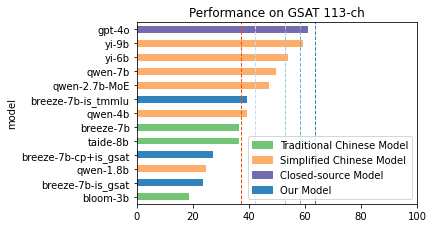

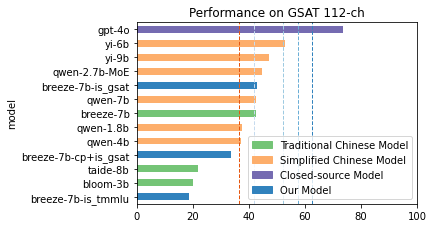

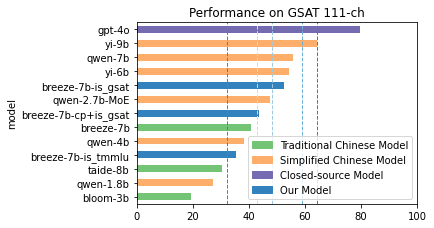

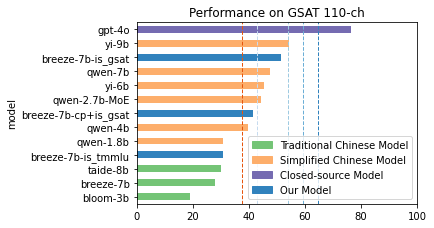

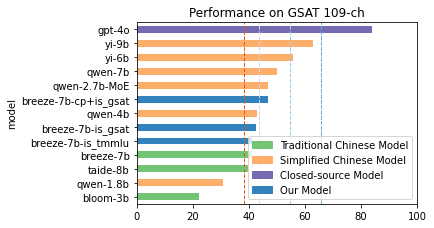

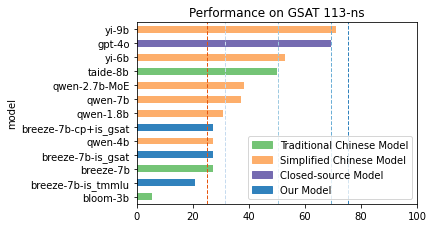

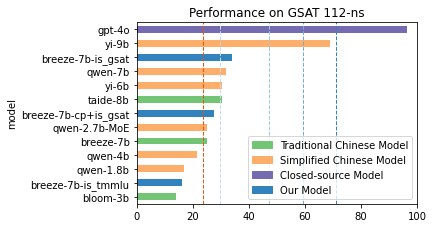

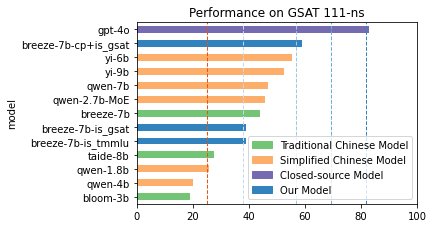

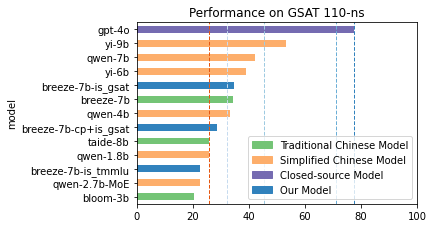

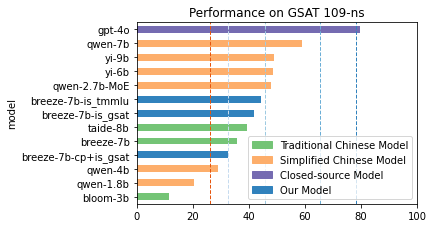

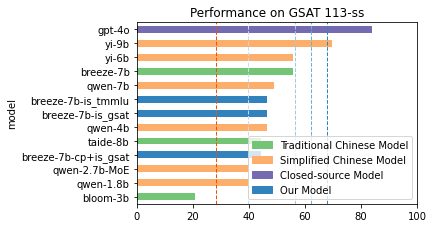

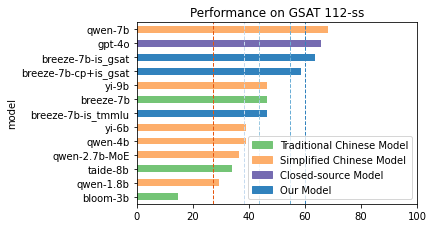

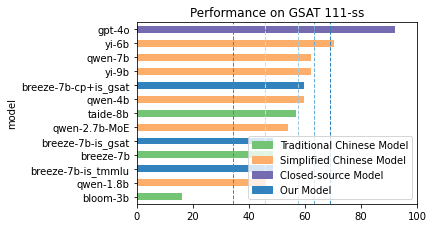

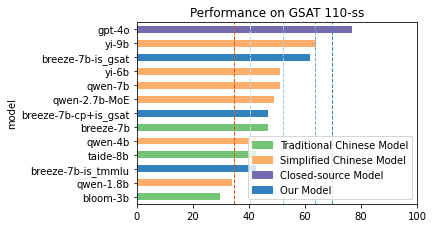

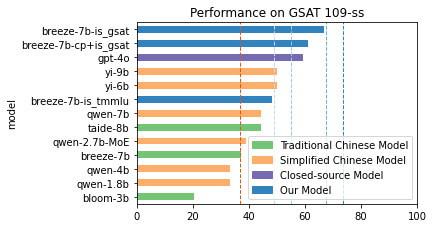

In [64]:
import re
for test_name in dataset_df["dataset_name"].values.tolist():
    dataset_row = dataset_df[dataset_df["dataset_name"] == test_name]
    scores = []
    # dataset_df.where(dataset_df["dataset_name"]==test_name)["path"].values[0]
    for _ , model in model_df.iterrows():
        try:
            model_test_df = pd.read_csv(f'./{test_name}-result-{model["short_name"]}.csv')
            scores.append(model_test_df["score"].sum())
        except:
            scores.append(0.0)

    model_df["score"] = scores
    model_df["score"] /= len(pd.read_csv(dataset_row["path"].values[0]).index)
    model_df["score"] *= 100
    model_df = model_df.sort_values(["score"])
    cm = matplotlib.colormaps["tab20c"]
    model_df.plot.barh(x='short_name', y='score', rot=0 , title=f"Performance on GSAT {test_name}" , xlabel="model" ,ylabel="score",figsize=(14,6) , color=[ cm.colors[0] if model["lora"] is True else cm.colors[12] if model["open"] is False else (cm.colors[9] if model["zh-tw"] is True else cm.colors[6]) for _,  model in model_df.iterrows() ] ,legend = False,xlim = [0,100])
    plt.axvline(x=dataset_row["1_tile"].values[0],linewidth=1,ls="--" ,color=cm.colors[0], label="12th")
    plt.axvline(x=dataset_row["2_tile"].values[0],linewidth=1,ls="--" ,color=cm.colors[1],label="25th")
    plt.axvline(x=dataset_row["3_tile"].values[0],linewidth=1,ls="--" ,color=cm.colors[2], label="50th")
    plt.axvline(x=dataset_row["4_tile"].values[0],linewidth=1,ls="--" ,color=cm.colors[3], label="75th")
    plt.axvline(x=dataset_row["5_tile"].values[0],linewidth=1,ls="--" ,color=cm.colors[4], label="88th")

    tw = mpatches.Patch(color=cm.colors[9], label='Traditional Chinese Model')
    cn = mpatches.Patch(color=cm.colors[6], label='Simplified Chinese Model')
    cs = mpatches.Patch(color=cm.colors[12], label='Closed-source Model')
    l = mpatches.Patch(color=cm.colors[0], label='Our Model')
    plt.legend(handles=[tw , cn , cs , l],loc='lower right')
    plt.subplot()

# Overall Performance on GSAT-113

<AxesSubplot:title={'center':'Performance on GSAT-113'}, ylabel='model'>

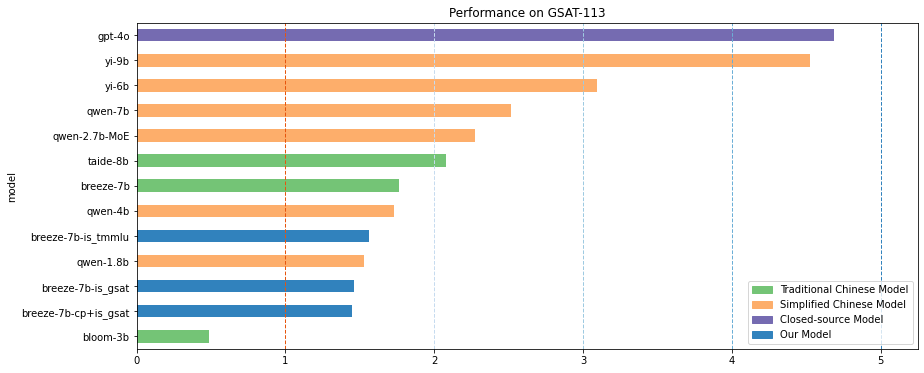

In [65]:
import numpy as np


def cal_rating(scores: list[float], tiles: list[float], q_num: int):
    assert len(tiles) == 5
    result = [0 for _ in range(len(scores))]
    for index, score in enumerate(scores):
        score = (score / q_num)*100
        if score > tiles[4]:
            rating = 5 + (score - tiles[4])/(100 - tiles[4])
        elif score > tiles[3]:
            rating = 4 + (score - tiles[3])/(tiles[4] - tiles[3])
        elif score > tiles[2]:
            rating = 3 + (score - tiles[2])/(tiles[3] - tiles[2])
        elif score > tiles[1]:
            rating = 2 + (score - tiles[1])/(tiles[2] - tiles[1])
        elif score > tiles[0]:
            rating = 1 + (score - tiles[0])/(tiles[1] - tiles[0])
        else:
            rating = score / (tiles[0])
        result[index] = rating
    return result


ratings = []
for test_name in dataset_df["dataset_name"].values.tolist():
    if test_name.startswith("113"):
        dataset_row = dataset_df[dataset_df["dataset_name"] == test_name]
        scores = []
    # dataset_df.where(dataset_df["dataset_name"]==test_name)["path"].values[0]
        for _, model in model_df.iterrows():
            try:
                model_test_df = pd.read_csv(
                    f'./{test_name}-result-{model["short_name"]}.csv')
                scores.append(model_test_df["score"].sum())
            except:
                scores.append(0.0)
        ratings.append(cal_rating(scores, dataset_row[[
                       "5_tile", "4_tile", "3_tile", "2_tile", "1_tile"]].values[0].tolist(), len(model_test_df)))
model_df["rating"] = np.average(ratings, axis=0)
model_df = model_df.sort_values(["rating"])
cm = matplotlib.colormaps["tab20c"]
model_df.plot.barh(x='short_name', y='rating', rot=0, title=f"Performance on GSAT-113", xlabel="model", figsize=(14, 6), color=[
                  cm.colors[0] if model["lora"] is True else cm.colors[12] if model["open"] is False else (cm.colors[9] if model["zh-tw"] is True else cm.colors[6]) for _,  model in model_df.iterrows()], legend=False, ylim=[0, 6])
plt.axvline(x=5, linewidth=1, ls="--", color=cm.colors[0], label="12th")
plt.axvline(x=4, linewidth=1, ls="--", color=cm.colors[1], label="25th")
plt.axvline(x=3, linewidth=1, ls="--", color=cm.colors[2], label="50th")
plt.axvline(x=2, linewidth=1, ls="--", color=cm.colors[3], label="75th")
plt.axvline(x=1, linewidth=1, ls="--", color=cm.colors[4], label="88th")

tw = mpatches.Patch(color=cm.colors[9], label='Traditional Chinese Model')
cn = mpatches.Patch(color=cm.colors[6], label='Simplified Chinese Model')
cs = mpatches.Patch(color=cm.colors[12], label='Closed-source Model')
l = mpatches.Patch(color=cm.colors[0], label='Our Model')
plt.legend(handles=[tw, cn, cs, l], loc='lower right')
plt.subplot()

''

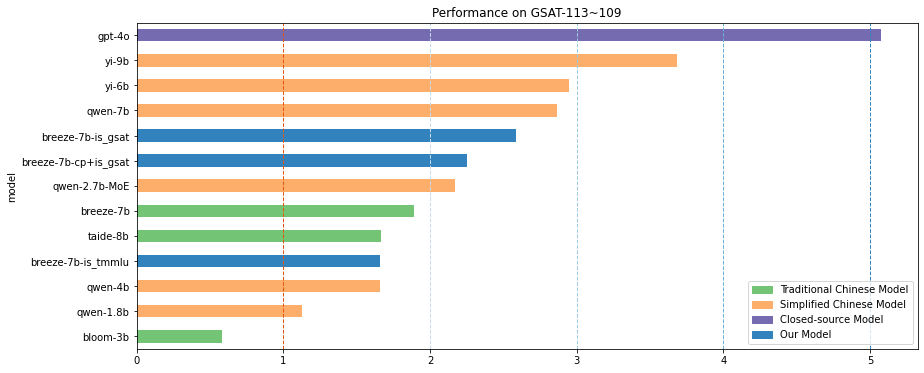

In [66]:
ratings = []
for test_name in dataset_df["dataset_name"].values.tolist():
    dataset_row = dataset_df[dataset_df["dataset_name"] == test_name]
    scores = []
# dataset_df.where(dataset_df["dataset_name"]==test_name)["path"].values[0]
    for _, model in model_df.iterrows():
        try:
            model_test_df = pd.read_csv(
                f'./{test_name}-result-{model["short_name"]}.csv')
            scores.append(model_test_df["score"].sum())
        except:
            scores.append(0.0)
    ratings.append(cal_rating(scores, dataset_row[[
                   "5_tile", "4_tile", "3_tile", "2_tile", "1_tile"]].values[0].tolist(), len(model_test_df)))
model_df["rating"] = np.average(ratings, axis=0)
model_df = model_df.sort_values(["rating"])
cm = matplotlib.colormaps["tab20c"]
model_df.plot.barh(x='short_name', y='rating', rot=0, title=f"Performance on GSAT-113~109", xlabel="model", figsize=(14, 6), color=[
                  cm.colors[0] if model["lora"] is True else cm.colors[12] if model["open"] is False else (cm.colors[9] if model["zh-tw"] is True else cm.colors[6]) for _,  model in model_df.iterrows()], legend=False, ylim=[0, 6])
plt.axvline(x=5, linewidth=1, ls="--", color=cm.colors[0], label="12th")
plt.axvline(x=4, linewidth=1, ls="--", color=cm.colors[1], label="25th")
plt.axvline(x=3, linewidth=1, ls="--", color=cm.colors[2], label="50th")
plt.axvline(x=2, linewidth=1, ls="--", color=cm.colors[3], label="75th")
plt.axvline(x=1, linewidth=1, ls="--", color=cm.colors[4], label="88th")

tw = mpatches.Patch(color=cm.colors[9], label='Traditional Chinese Model')
cn = mpatches.Patch(color=cm.colors[6], label='Simplified Chinese Model')
cs = mpatches.Patch(color=cm.colors[12], label='Closed-source Model')
l = mpatches.Patch(color=cm.colors[0], label='Our Model')
plt.legend(handles=[tw, cn, cs, l], loc='lower right')
ax = plt.subplot()
""